# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix,roc_curve,auc,accuracy_score,classification_report,roc_auc_score

from tqdm import tqdm
from bs4 import BeautifulSoup

from gensim.models import Word2Vec

D:\Continuum\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
D:\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\Study_materials\Applied_AI\Assignments\database.sqlite') 

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (525814, 10)


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [3]:
#Deduplication of entries
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [4]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [7]:
final = final.sort_values(['Time'], axis = 0)

In [8]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


#  [3] Preprocessing

In [9]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# Code to remove URLs,HTML tags, words with numbers and special characters, making words lower
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:37<00:00, 1677.67it/s]


In [12]:
final['cleanText'] = preprocessed_reviews

In [13]:
positive = final[final['Score']==1].head(1000)
negative = final[final['Score']==0].head(1000)
final_2000 = pd.concat([positive,negative])

In [14]:
final_2000.shape

(2000, 11)

In [15]:
score_2000 = final_2000['Score']

In [16]:
count_vec = CountVectorizer(ngram_range=(1,2))
final_bigrams_count = count_vec.fit_transform(final_2000['cleanText'].values)

In [17]:
print("Count vectorizer is of type: ",type(final_bigrams_count))
print("the shape of BOW vectorizer is : ",final_bigrams_count.get_shape())
print("the number of unique words including both unigrams and bigrams is : ", final_bigrams_count.get_shape()[1])

Count vectorizer is of type:  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer is :  (2000, 83602)
the number of unique words including both unigrams and bigrams is :  83602


In [18]:
std_data = StandardScaler(with_mean = False).fit_transform(final_bigrams_count)
std_data.shape

D:\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(2000, 83602)

In [19]:
std_data = std_data.toarray()

## T-SNE for BOW

D:\Continuum\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


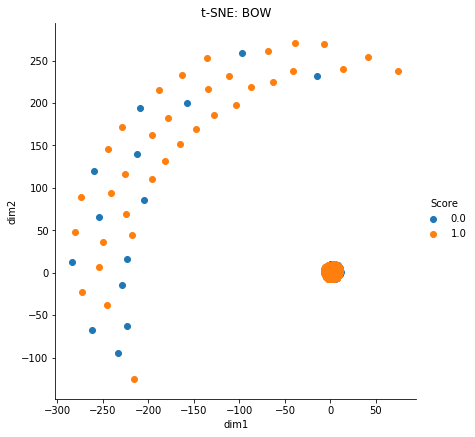

In [20]:
model1 = TSNE(n_components = 2,random_state = 0, perplexity = 30, n_iter = 5000)
        
tsne_data = model1.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T,score_2000)).T
tsne_df = pd.DataFrame(tsne_data, columns = ("dim1","dim2","Score"))
        
sns.FacetGrid(tsne_df, hue = 'Score', size =6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title('t-SNE: BOW')
plt.show()

## T-SNE for TF-IDF

In [21]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2))
final_tfidf = tfidf_vec.fit_transform(final_2000['cleanText'].values)

In [22]:
std_tfidf_data = StandardScaler(with_mean=False).fit_transform(final_tfidf)

In [23]:
type(std_tfidf_data)

scipy.sparse.csr.csr_matrix

In [24]:
#Convert sparse matrix to dense vector

std_tfidf_data = std_tfidf_data.toarray()

D:\Continuum\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


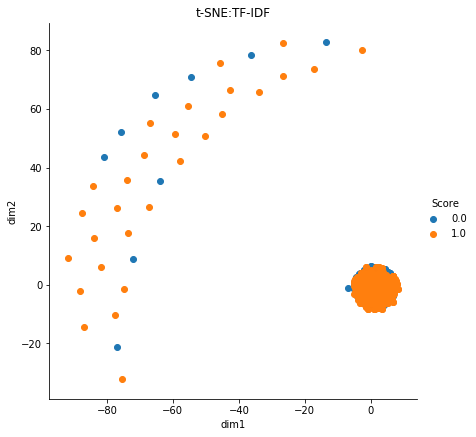

In [25]:
model2 = TSNE(n_components = 2, perplexity = 50)

tsne_tfidf_data = model2.fit_transform(std_tfidf_data)
tsne_tfidf_data = np.vstack((tsne_tfidf_data.T,score_2000)).T
tsne_tfidf_df = pd.DataFrame(tsne_tfidf_data, columns = ("dim1","dim2","Score"))

sns.FacetGrid(tsne_tfidf_df, hue='Score', size = 6).map(plt.scatter,"dim1","dim2").add_legend()
plt.title('t-SNE:TF-IDF')
plt.show()

## T-SNE for AVG W2V:

In [26]:
w2v_data = final_2000['cleanText']

splitted = []
for row in w2v_data: 
    splitted.append([word for word in row.split()])     #splitting words

In [27]:
print(final_2000['cleanText'].values[6])
print("------------------------------------------------------------------------------------------------------------------------")
print(splitted[6])

bought apartment infested fruit flies hours trap attracted many flies within days practically gone may not long term solution flies driving crazy consider buying one caution surface sticky try avoid touching
------------------------------------------------------------------------------------------------------------------------
['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'flies', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'flies', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching']


In [28]:
len(splitted)

2000

In [29]:
model_w2v = Word2Vec(splitted,min_count=5,size=50, workers=4)

In [30]:
w2v = list(model_w2v[model_w2v.wv.vocab])

In [31]:
model_w2v.wv.most_similar('like')

[('really', 0.9998146295547485),
 ('tasted', 0.9997965693473816),
 ('good', 0.9997961521148682),
 ('taste', 0.9997891783714294),
 ('love', 0.999788761138916),
 ('sweet', 0.9997806549072266),
 ('stuff', 0.999772310256958),
 ('mouth', 0.9997715353965759),
 ('eating', 0.9997625350952148),
 ('better', 0.9997614622116089)]

In [32]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in splitted: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [34]:
np.isnan(sent_vectors)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [35]:
sntc_vec=np.nan_to_num(sent_vectors)

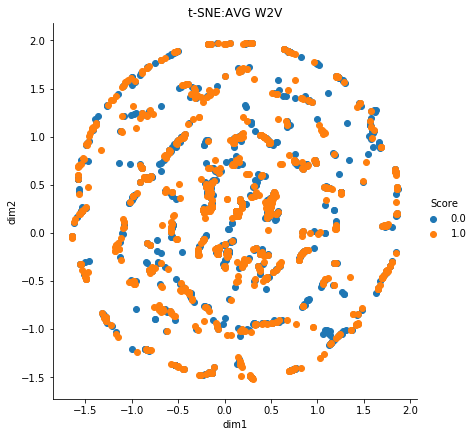

In [36]:
model3 = TSNE(n_components = 2, perplexity = 30, n_iter = 5000,random_state=0)
tsne_aw2v_data = model3.fit_transform(sntc_vec)
tsne_aw2v_data = np.vstack((tsne_aw2v_data.T,score_2000)).T
tsne_aw2v_df = pd.DataFrame(tsne_aw2v_data, columns = ("dim1","dim2","Score"))

sns.FacetGrid(tsne_aw2v_df, hue='Score', height = 6).map(plt.scatter, 'dim1','dim2').add_legend()
plt.title("t-SNE:AVG W2V")
plt.show()

## t-SNE on TF-IDF W2V

In [37]:
tf_w_data = final_2000['cleanText']
tf_idf = TfidfVectorizer(max_features=5000)
tf_idf_data = tf_idf.fit_transform(tf_w_data)
final_tf_w2v_data = []
tf_idf_data = tf_idf_data.toarray()
i = 0
splitted = []

for row in tf_w_data: 
    splitted.append([word for word in row.split()])
for row in tqdm(splitted):
    vec = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    count = 0
    tf_idf_sum = 0
    for word in row:
        try:
            count += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[count-1]
            vec += (temp_tfidf[count-1] * train_w2v[word])
        except:
            pass
    #print(vec)
    try:
        vec = (float)(1/tf_idf_sum) * vec
    except:
        pass
    final_tf_w2v_data.append(vec)
    i = i + 1

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 571.08it/s]


In [38]:
len(final_tf_w2v_data)

2000

In [39]:
np.isnan(final_tf_w2v_data)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [40]:
# Convert NaN value to 0 and infinite value to a finite value

#final_tf_w2v_data = np.nan_to_num(final_tf_w2v_data)

D:\Continuum\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


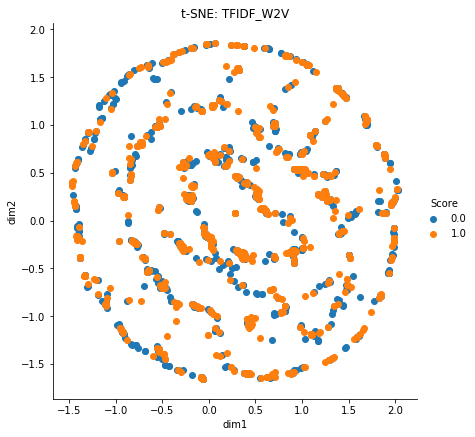

In [41]:
model4 = TSNE(n_components = 2, perplexity = 50, n_iter = 5000,random_state = 0)

tsne_tfw2v_data = model4.fit_transform(final_tf_w2v_data)
tsne_tfw2v_data = np.vstack((tsne_tfw2v_data.T,score_2000)).T
tsne_tfw2v_df = pd.DataFrame(tsne_tfw2v_data, columns = ("dim1","dim2","Score"))

sns.FacetGrid(tsne_tfw2v_df, hue = 'Score', size = 6).map(plt.scatter, 'dim1','dim2').add_legend()
plt.title('t-SNE: TFIDF_W2V')
plt.show()

## Conclusion


From the above 4 visualizations, none of the above gives a clear segregation between positive and negative reviews. Both positive and negative reviews are overlapped.